In [1]:
import os
import random
import shutil
import keras
import numpy as np
import tensorflow as tf
from tensorflow import image as tfi
from keras.datasets import cifar100


# Data Viz
import matplotlib.pyplot as plt

# Data Aug
from keras.layers import Normalization
from keras.layers import Resizing
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom

# Model
from tensorflow.nn import gelu
from keras.models import Model
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import MultiHeadAttention
from keras.layers import LayerNormalization
from keras.layers import Add
from keras.layers import Flatten

# Compiling
from keras.losses import SparseCategoricalCrossentropy as SCCe
from tensorflow.keras.optimizers import AdamW
from keras.metrics import SparseCategoricalAccuracy as Acc
from keras.metrics import SparseTopKCategoricalAccuracy as KAcc

# Callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [2]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [3]:
SIZE = 72
PATCH_SIZE = 6
LR = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 50
NUM_PATCHES = (SIZE // PATCH_SIZE) ** 2
PROJECTION_DIMS = 64
NUM_HEADS = 4
HIDDEN_UNITS = [PROJECTION_DIMS*2, PROJECTION_DIMS]
OUTPUT_UNITS = [2048,1024]

In [4]:
#train_path = 'C:\\Users\\gouth\\Downloads\\archive (5)\\tomato\\train'
#val_path = 'C:\\Users\\gouth\\Downloads\\archive (5)\\tomato\\val'
train_path = 'C:\\Users\\gouth\\OneDrive\\Documents\\Capstone Work\\PlantVillage'
# Create directories if they don't exist
#os.makedirs(train_path, exist_ok=True)
#os.makedirs(val_path, exist_ok=True)
#os.makedirs(test_path, exist_ok=True)


In [5]:
classes = []


directory_contents = os.listdir(train_path)

folder_names = [item for item in directory_contents if os.path.isdir(os.path.join(train_path, item))]

# Save folder names in the 'classes' list
classes.extend(folder_names)

In [6]:
print(classes)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [6]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="training"
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,  # Adjusted to 20% of the remaining 80% (i.e., 20% of the total)
    subset="validation"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    seed=101,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.1,  # 10% of the total data for testing
    subset="validation"
)


Found 16099 files belonging to 13 classes.
Using 12880 files for training.
Found 16099 files belonging to 13 classes.
Using 3219 files for validation.
Found 16099 files belonging to 13 classes.
Using 1609 files for validation.


In [7]:
class DataAugmentation(Layer):
    def __init__(self, norm, SIZE):
        super(DataAugmentation, self).__init__()
        self.norm = norm
        self.SIZE = SIZE
        self.resize = Resizing(SIZE, SIZE)
        self.flip = RandomFlip('horizontal')
        self.rotation = RandomRotation(factor=0.02)
        self.zoom = RandomZoom(height_factor=0.2, width_factor=0.2)
    def call(self, X):
        x = self.norm(X)
        x = self.resize(x)
        x = self.flip(x)
        x = self.rotation(x)
        x = self.zoom(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
        "norm": self.norm,
        "SIZE": self.SIZE,
        })
        return config

In [8]:
class Patches(Layer):

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] # Get the Batch Size
        patches = tfi.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "path-size": self.patch_size,
        })
        return config

In [10]:
class Transformer(Layer):
    def __init__(self, L, num_heads, key_dims, hidden_units):
        super(Transformer, self).__init__()
        self.L = L
        self.heads = num_heads
        self.key_dims = key_dims
        self.hidden_units = hidden_units

        self.norm = LayerNormalization(epsilon=1e-6)  # Remember the Params
        self.MHA = MultiHeadAttention(num_heads=num_heads, key_dim=key_dims, dropout=0.1)
        self.net = MLP(units=hidden_units, rate=0.1)
        self.add = Add()

    def call(self, X):
        inputs = X
        x = X
        for _ in range(self.L):
            x = self.norm(x)
            x = self.MHA(x, x)  # our Target and the Source element are the same
            y = self.add([x, inputs])
            x = self.norm(y)
            x = self.net(x)
            x = self.add([x, y])
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "L": self.L,
            "heads": self.heads,
            "key_dims": self.key_dims,
            "hidden_units": self.hidden_units
        })
        return config

In [11]:
import numpy as np
X_train = []
y_train = []
# Iterate through the training dataset
for images, labels in train_ds:

    X_train.extend(images.numpy())  # Append the images to X_train
    y_train.extend(labels.numpy())  # Append the labels to y_train

# Converting the lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

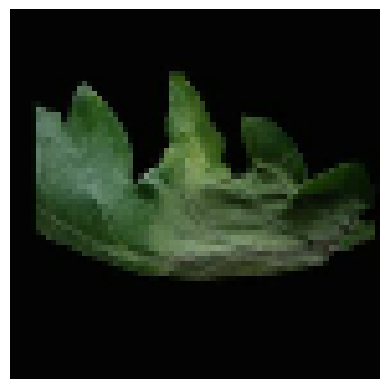

In [12]:
image = X_train[np.random.randint(len(X_train))]
image = tfi.resize(image, (SIZE, SIZE))
image = tf.cast(image,'uint8')
show_image(image)
image = tf.expand_dims(image,0)

In [13]:
patch = Patches(PATCH_SIZE) # patch Size
patches = patch(image)
patches.shape # We needed 12 patches


TensorShape([1, 144, 108])

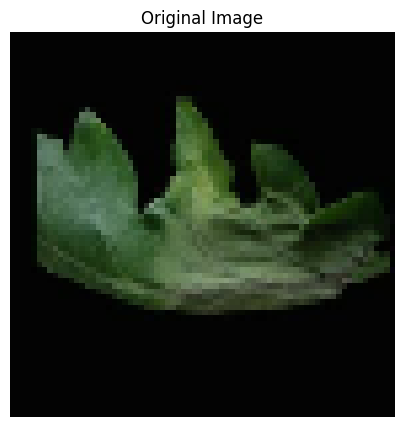

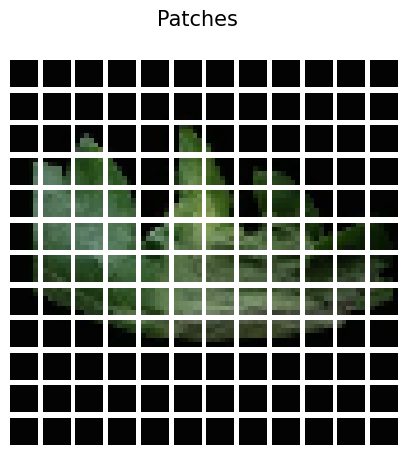

In [14]:
plt.figure(figsize=(5,5))
show_image(image[0], title="Original Image")
plt.show()

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(5,5))
plt.suptitle("Patches", fontsize=15)
for i in range(patches.shape[-2]):
    plt.subplot(n,n,i+1)
    patch = tf.reshape(patches[0][i],(PATCH_SIZE, PATCH_SIZE, 3))
    patch = tf.cast(patch, 'uint8')
    show_image(patch, cmap='gray')
plt.show()

In [15]:
class PatchEncoder(Layer):

    def __init__(self, num_patches, projection_dims): # Projection dims is  D
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.d = projection_dims

        self.dense = Dense(units=projection_dims)
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=projection_dims)

    def call(self, X):
        positions = tf.range(0,limit=self.num_patches, delta=1)
        encoded = self.dense(X) + self.positional_embeddings(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_paches": self.num_patches,
            "d": self.d,
        })
        return config

In [16]:
class MLP(Layer):
    def __init__(self, units, rate):
        super(MLP, self).__init__()
        self.units = units
        self.rate = rate
        self.layers = [[Dense(unit, activation=gelu), Dropout(rate)] for unit in units]

    def call(self, x):
        for layers in self.layers:
            for layer in layers:
                x = layer(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "rate": self.rate,
        })
        return config


In [17]:
class_names = train_ds.class_names

In [18]:
    input_shape = X_train.shape[1:]
    print(f'Input Image Shape : {input_shape}')

Input Image Shape : (224, 224, 3)


In [19]:
# Input Layer
inputs = Input(shape=input_shape)

# Apply Data Aug
norm = Normalization()
norm.adapt(X_train)

x = DataAugmentation(norm, SIZE)(inputs)

# Get Patches
x = Patches(PATCH_SIZE)(x)

# PatchEncoding Network
x = PatchEncoder(NUM_PATCHES, PROJECTION_DIMS)(x)

# Transformer Network
x = Transformer(8, NUM_HEADS, PROJECTION_DIMS, HIDDEN_UNITS)(x)

# Output Network
x = LayerNormalization(epsilon=1e-6)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = MLP(OUTPUT_UNITS, rate=0.5)(x)

# Ouput Layer
outputs = Dense(100)(x)

In [20]:
with tf.device('/GPU:0'):
  # Model
  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  # Compiling
  model.compile(
      loss=SCCe(from_logits=True),
      optimizer=AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
      metrics=[
          Acc(name="Accuracy"),
          KAcc(5, name="Top-5-Accuracy")
      ]
  )

  # Callbacks
  cbs = [
    ModelCheckpoint("ViT-Model2.keras", save_best_only=True)
  ]

In [21]:
results = model.fit(
      train_ds,
      epochs=50,
      validation_data=valid_ds,
      callbacks=cbs
  )

Epoch 1/50


403/403 ━━━━━━━━━━━━━━━━━━━━ 184s 438ms/step - Accuracy: 0.1686 - Top-5-Accuracy: 0.5463 - loss: 4.3357 - val_Accuracy: 0.5502 - val_Top-5-Accuracy: 0.9136 - val_loss: 1.4502
Epoch 2/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 188s 466ms/step - Accuracy: 0.3893 - Top-5-Accuracy: 0.8154 - loss: 1.8711 - val_Accuracy: 0.6213 - val_Top-5-Accuracy: 0.9506 - val_loss: 1.2406
Epoch 3/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 191s 475ms/step - Accuracy: 0.4911 - Top-5-Accuracy: 0.8924 - loss: 1.5335 - val_Accuracy: 0.6713 - val_Top-5-Accuracy: 0.9509 - val_loss: 1.0745
Epoch 4/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 182s 451ms/step - Accuracy: 0.5710 - Top-5-Accuracy: 0.9325 - loss: 1.2968 - val_Accuracy: 0.7276 - val_Top-5-Accuracy: 0.9823 - val_loss: 0.8807
Epoch 5/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 182s 452ms/step - Accuracy: 0.6204 - Top-5-Accuracy: 0.9475 - loss: 1.1477 - val_Accuracy: 0.7422 - val_Top-5-Accuracy: 0.9792 - val_loss: 0.8064
Epoch 6/50
403/403 ━━━━━━━━━━━━━━━━━━━━ 177s 439ms/step - Accuracy: 0.6611 - Top-

In [23]:
import numpy as np
import tensorflow as tf

class ABCOptimizer:
    def __init__(self, population_size, iterations, model, data, decrease_factor=0.99):
        self.population_size = population_size
        self.iterations = iterations
        self.model = model
        self.data = data
        self.decrease_factor = decrease_factor
        self.populations = [self.model.get_weights() for _ in range(population_size)]
        self.fitness = [float('inf')] * population_size

    def evaluate_population(self):
        for i in range(self.population_size):
            self.model.set_weights(self.populations[i])
            results = self.model.evaluate(self.data, verbose=0)
            loss = results if isinstance(results, float) else results[0]
            self.fitness[i] = loss

    def optimize(self):
        phi = 1.0
        for _ in range(self.iterations):
            phi *= self.decrease_factor  # Gradually decrease the exploration/exploitation factor
            self.explore(phi)
            self.exploit(phi)
            self.evaluate_population()
            best_idx = np.argmin(self.fitness)
            self.model.set_weights(self.populations[best_idx])

    def explore(self, phi):
        for i in range(self.population_size):
            j = np.random.randint(self.population_size)
            while j == i:
                j = np.random.randint(self.population_size)

            new_weights = []
            for idx in range(len(self.populations[i])):
                change_factor = np.random.uniform(-phi, phi)
                change_vector = change_factor * (self.populations[i][idx] - self.populations[j][idx])
                new_weight = self.populations[i][idx] + change_vector
                new_weights.append(new_weight)

            self.model.set_weights(new_weights)
            results = self.model.evaluate(self.data, verbose=0)
            new_loss = results if isinstance(results, float) else results[0]

            if new_loss < self.fitness[i]:
                self.populations[i] = new_weights
                self.fitness[i] = new_loss

    def exploit(self, phi):
        best_idx = np.argmin(self.fitness)

        for i in range(self.population_size):
            if i != best_idx:
                new_weights = []
                for idx in range(len(self.populations[i])):
                    change_factor = np.random.uniform(-phi/2, phi/2)
                    change_vector = change_factor * (self.populations[best_idx][idx] - self.populations[i][idx])
                    new_weight = self.populations[i][idx] + change_vector
                    new_weights.append(new_weight)

                self.model.set_weights(new_weights)
                results = self.model.evaluate(self.data, verbose=0)
                new_loss = results if isinstance(results, float) else results[0]

                if new_loss < self.fitness[i]:
                    self.populations[i] = new_weights
                    self.fitness[i] = new_loss


In [24]:
# Initialize and run the ABC optimizer
optimizer = ABCOptimizer(
    population_size=10,
    iterations=10,
    model=model,
    data=train_ds  # Ensure this dataset is correctly prepared for evaluation as needed
)

# Optimize the model
optimizer.optimize()

In [25]:
test_accuracy = model.evaluate(test_ds)
print("Test Accuracy:", test_accuracy[1])

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - Accuracy: 0.9369 - Top-5-Accuracy: 0.9962 - loss: 0.2231
Test Accuracy: 0.9341205954551697


In [26]:

# Define a list to store predictions
predictions = []

# Define a function to extract images from the dataset
def extract_images(image, label):
    return image

# Apply the function to 'valid_ds' to extract only images
valid_ds_images = valid_ds.map(extract_images)

# Iterate through the dataset and make predictions for each image
for image in valid_ds_images:
    prediction = model.predict(image)
    predictions.append(prediction)

# Now, 'predictions' contains the predictions for each image in the 'valid_ds' dataset


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

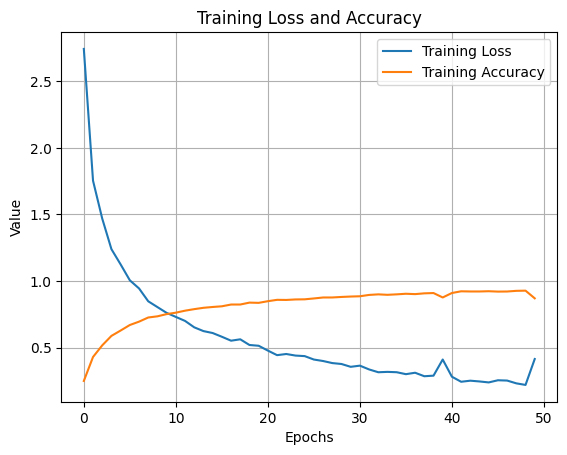

In [27]:
import matplotlib.pyplot as plt

# Assuming 'results' contains the training history
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['Accuracy'], label='Training Accuracy')  # Change to 'accuracy' if that's the metric you're using
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()

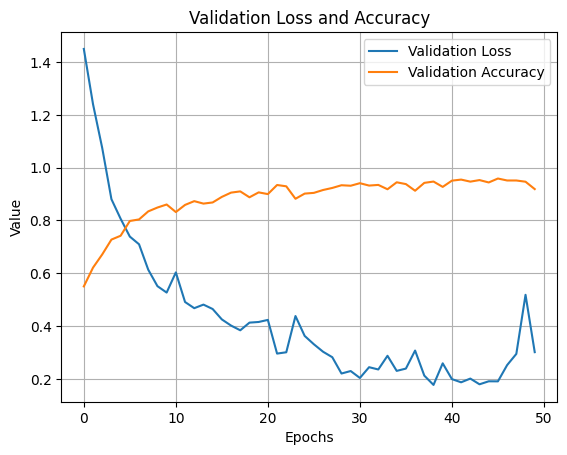

In [28]:
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.plot(results.history['val_Accuracy'], label='Validation Accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Validation Loss and Accuracy')
plt.legend()
plt.show()

In [29]:
accuracy = model.evaluate(test_ds)
print("Test Accuracy:", accuracy[1])

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - Accuracy: 0.9417 - Top-5-Accuracy: 0.9946 - loss: 0.2389 
Test Accuracy: 0.9341205954551697


In [41]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt



test_ds 

X_test = []
y_test = []

# Iterate through the test dataset
for images, labels in test_ds:
    X_test.extend(images.numpy())  # Append the images to X_test
    y_test.extend(labels.numpy())  # Append the labels to y_test

# Converting the lists to NumPy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Make predictions using the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='macro')
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")



51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step
Accuracy: 0.93
F1 Score: 0.92
Precision: 0.93
Recall: 0.92


In [49]:
from sklearn.metrics import classification_report

# Generate the classification report using actual class names
class_report = classification_report(y_test, y_pred_classes, target_names=classes)

# Print the classification report
print("Classification Report:")
print(class_report)



Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.94      0.91      0.92        87
                     Pepper__bell___healthy       0.94      0.98      0.96       168
                      Potato___Early_blight       0.95      1.00      0.98       100
                           Potato___healthy       0.95      0.92      0.93        96
                       Potato___Late_blight       0.94      0.65      0.77        23
                      Tomato_Bacterial_spot       0.95      0.98      0.96       214
                        Tomato_Early_blight       0.82      0.89      0.86        90
                         Tomato_Late_blight       0.96      0.91      0.94       169
                           Tomato_Leaf_Mold       0.89      0.96      0.92        95
                  Tomato_Septoria_leaf_spot       0.97      0.90      0.94       189
Tomato_Spider_mites_Two_spotted_spider_mi

In [47]:
classes = []


directory_contents = os.listdir(train_path)

folder_names = [item for item in directory_contents if os.path.isdir(os.path.join(train_path, item))]

# Save folder names in the 'classes' list
classes.extend(folder_names)

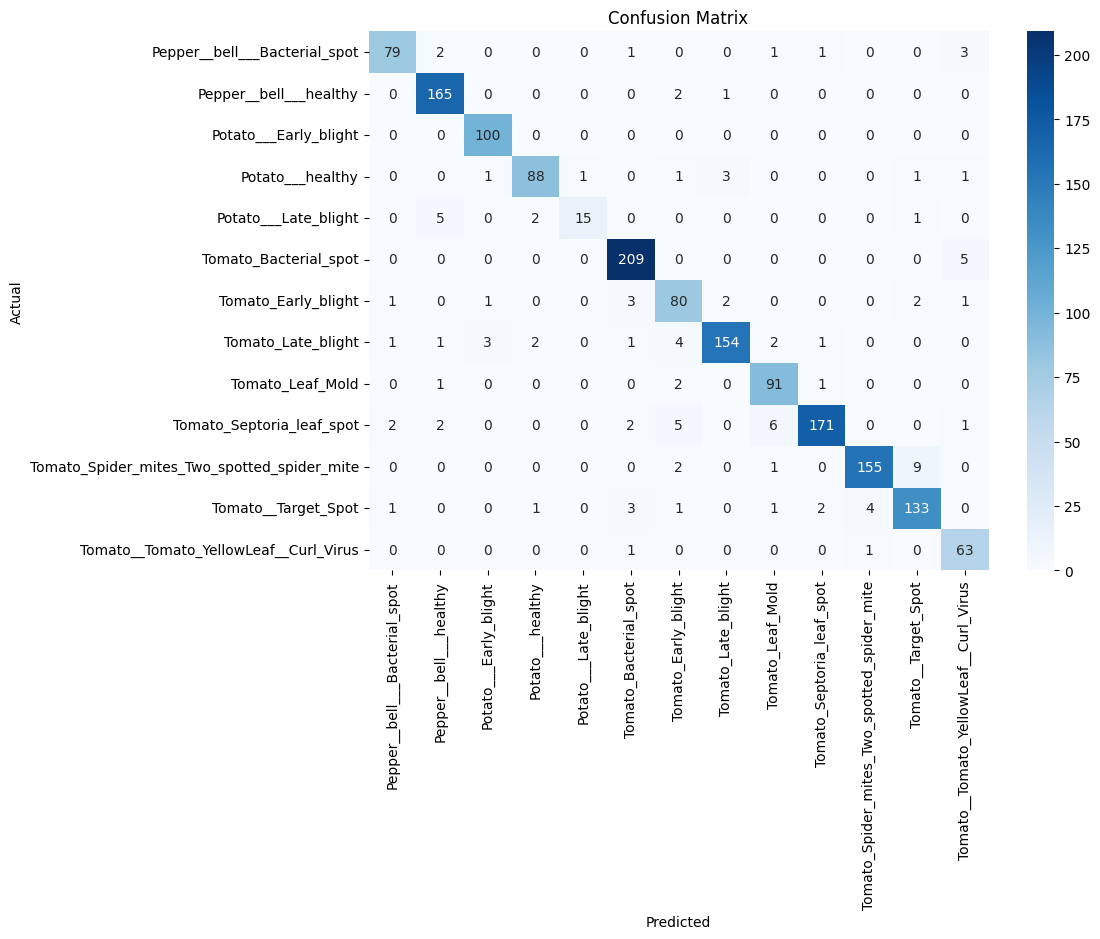

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_test and y_pred_classes are already defined as shown previously

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


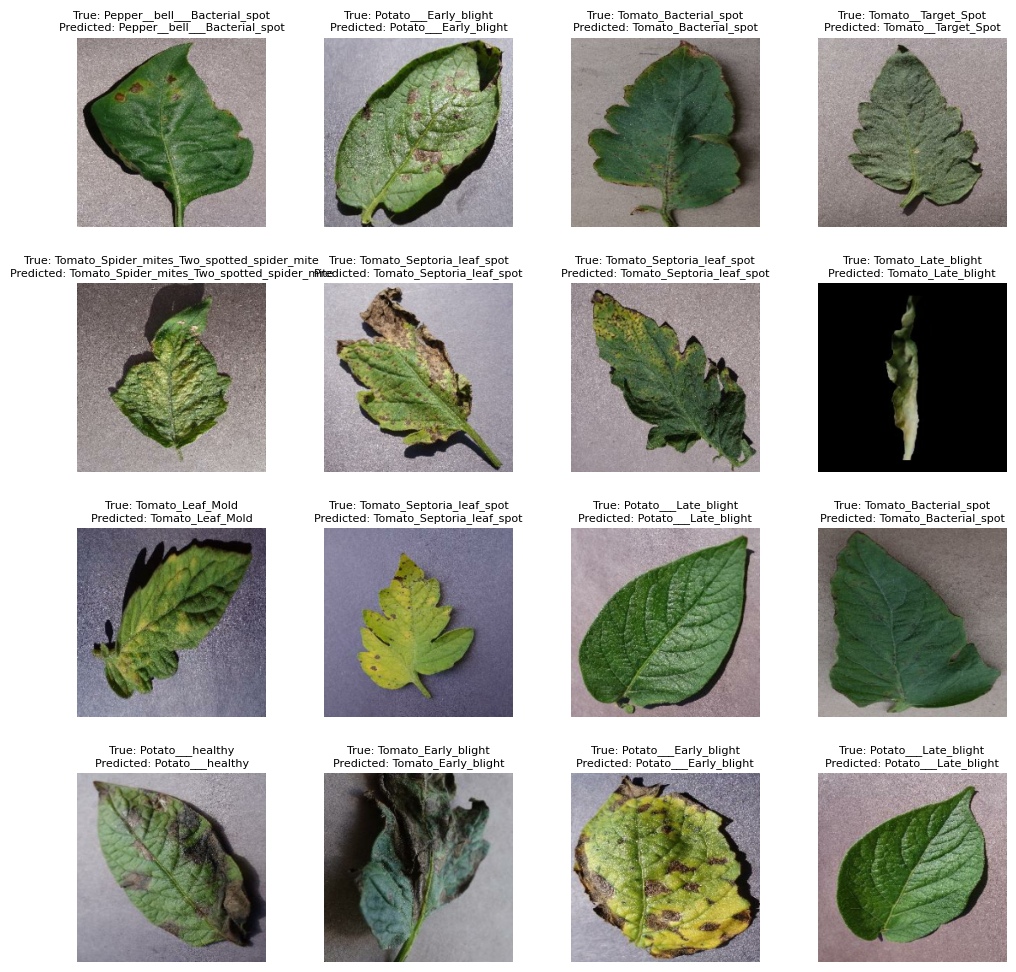

In [51]:
num_rows = 4
num_cols = 4
grid_size = num_rows * num_cols
num_images = len(X_test)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Loop through the grid positions and plot the images
for i in range(grid_size):
    if i >= num_images:
        break

    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(X_test[i] / 255.0)  # Normalize the image for display
    true_label = classes[y_test[i]]
    pred_label = classes[y_pred_classes[i]]
    ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=8)
    ax.axis('off')  # Hide the axis

# Remove unused axes if the grid size exceeds the number of images
for i in range(grid_size, num_rows * num_cols):
    fig.delaxes(axes[i // num_cols, i % num_cols])

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()
